In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.projections import PolarAxes
import mpl_toolkits.axisartist.floating_axes as floating_axes
import mpl_toolkits.axisartist.angle_helper as angle_helper
from mpl_toolkits.axisartist.grid_finder import FixedLocator, MaxNLocator, DictFormatter

from astropy.table import Table
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM, z_at_value

from scipy.spatial import cKDTree, ConvexHull

from sympy import solve_poly_system, im
from sympy.abc import x,y

matplotlib.rcParams.update({'font.size': 38})

In [2]:
#Coordinate Transforms
D2R = np.pi/180.

def toSky(cs):
    c1  = cs.T[0]
    c2  = cs.T[1]
    c3  = cs.T[2]
    r   = np.sqrt(c1**2.+c2**2.+c3**2.)
    dec = np.arcsin(c3/r)/D2R
    ra  = (np.arccos(c1/np.sqrt(c1**2.+c2**2.))*np.sign(c2)/D2R)%360
    return r,ra,dec

def toCoord(r,ra,dec):
    c1 = r*np.cos(ra*D2R)*np.cos(dec*D2R)
    c2 = r*np.sin(ra*D2R)*np.cos(dec*D2R)
    c3 = r*np.sin(dec*D2R)
    return c1,c2,c3

In [3]:
#Actual plotting
def setup_axes3(fig, rect):
    """
    Sometimes, things like axis_direction need to be adjusted.
    """

    # rotate a bit for better orientation
    tr_rotate = Affine2D().translate(-225, 0)

    # scale degree to radians
    tr_scale = Affine2D().scale(np.pi/180., 1.)

    tr = tr_rotate + tr_scale + PolarAxes.PolarTransform()

    grid_locator1 = angle_helper.LocatorDMS(4)
    tick_formatter1 = angle_helper.FormatterDMS()
        
    grid_locator2 = MaxNLocator(3)

    ra0, ra1 = 190, 260
    cz0, cz1 = 0., 400.
    grid_helper = floating_axes.GridHelperCurveLinear(tr,
                                        extremes=(ra0, ra1, cz0, cz1),
                                        grid_locator1=grid_locator1,
                                        grid_locator2=grid_locator2,
                                        tick_formatter1=tick_formatter1,
                                        tick_formatter2=None,
                                        )

    ax1 = floating_axes.FloatingSubplot(fig, rect, grid_helper=grid_helper)
    fig.add_subplot(ax1)

    # adjust axis
    ax1.axis["left"].set_axis_direction("bottom")
    ax1.axis["right"].set_axis_direction("top")

    ax1.axis["bottom"].set_visible(False)
    ax1.axis["top"].set_axis_direction("bottom")
    ax1.axis["top"].toggle(ticklabels=True, label=True)
    ax1.axis["top"].major_ticklabels.set_axis_direction("top")
    ax1.axis["top"].label.set_axis_direction("top")

    ax1.axis["left"].label.set_text(r"r [Mpc h$^{-1}$]")
    ax1.axis["top"].label.set_text(r"$\alpha$")


    # create a parasite axes whose transData in RA, cz
    aux_ax = ax1.get_aux_axes(tr)

    aux_ax.patch = ax1.patch # for aux_ax to have a clip path as in ax
    ax1.patch.zorder=0.8 # but this has a side effect that the patch is
                        # drawn twice, and possibly over some other
                        # artists. So, we decrease the zorder a bit to
                        # prevent this.
    aux_ax.set_facecolor("white")

    return ax1, aux_ax

In [15]:
def plot(table, dec, width):
    fig = plt.figure(1,figsize=(1600/96,800/96))
    ax3, aux_ax3 = setup_axes3(fig,111)
    gdcut = (table['dis']*np.sin((table['DEC']-dec)*D2R))**2.<width**2.
    aux_ax3.scatter(table['RA'][gdcut],table['dis'][gdcut],color='black',s=1)
    
    #Adding in Bootes void
    aux_ax3.plot(152,222,color='blue')
    
    return fig

In [16]:
from vast.voidfinder.distance import z_to_comoving_dist
KOSS87 = Table.read('/home/codebind/Bootes/KOSS87.csv', format='ascii.csv')
KOSS87['dis']= z_to_comoving_dist(np.array(KOSS87['Redshift'],dtype=np.float32),0.315,1)

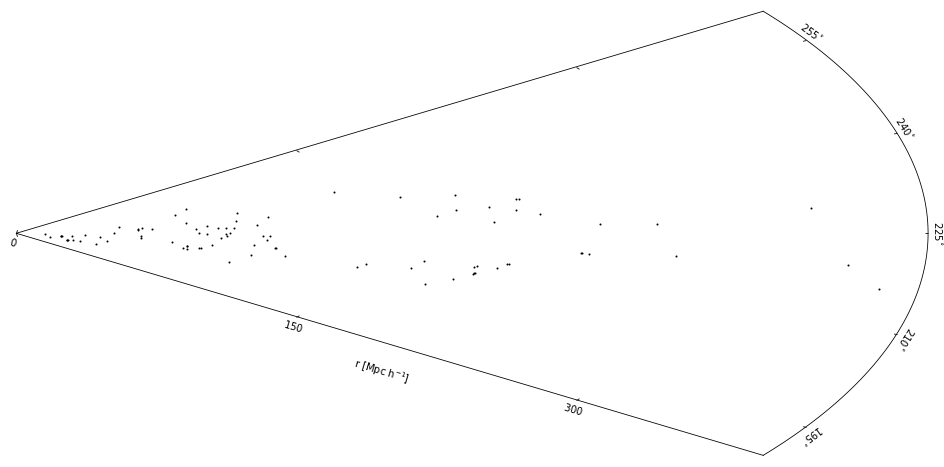

In [23]:
fig = plot(KOSS87,46,10)
fig.savefig('KOSS87.png', dpi = 480)

In [7]:
print(z_to_comoving_dist(np.array([15500/300000],dtype=np.float32),0.315,1))

[152.98419]
